In [3]:
import sys
sys.path.append(r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\src\neuraloperator")

In [4]:
import torch
import matplotlib.pyplot as plt
import sys
import os
from src import FNO, UNO ,GINO, UQNO , FNOGNO, TFNO, CODANO
from src.neuraloperator.neuralop import Trainer
from src.neuraloperator.neuralop.training import AdamW
from src.neuraloperator.neuralop.data.datasets import load_darcy_flow_small
from src.neuraloperator.neuralop.utils import count_model_params
from src.neuraloperator.neuralop import LpLoss, H1Loss
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn.functional as F
sys.path.append(r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network")
from src.Operators.Diff_Op import pdeOperator



In [5]:
class quickCNN(nn.Module):
    def __init__(self, N_input, N_output, N_Hidden, N_layers, kernel_size=3, num_filters=16):
        """

        Args:
            N_input (int): Input feature size.
            N_output (int): Output size.
            N_Hidden (int): Number of hidden neurons (used for FC layer after CNN).
            N_layers (int): Number of hidden layers.
            kernel_size (int): Size of convolutional kernel.
            num_filters (int): Number of filters in convolution layers.
        """
        super(quickCNN, self).__init__()
        activation = nn.Tanh()

        # Initial Convolutional layer (Mimics First Linear Layer)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=N_input, out_channels=num_filters, kernel_size=kernel_size, padding=1),
            activation
        )

        # Hidden Convolutional Layers (Mimics Hidden Fully Connected Layers)
        self.conv_hidden = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1),
                    activation
                ) for _ in range(N_layers)
            ]
        )

        # Fully Connected Layer (To map CNN features to output)
        self.fc = nn.Sequential(
            nn.Linear(num_filters, N_Hidden),  # Flattened CNN output
            activation,
            nn.Linear(N_Hidden, N_output)
        )

    def forward(self, x):
        """
        Forward pass through the CNN model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, N_input)
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, N_output)
        """
        # Reshape input to fit CNN (Batch, Channels, Features)
        #x = x.unsqueeze(1)  # Convert (Batch, Features) -> (Batch, Channels=1, Features)

        # Apply convolutional layers
        x = self.conv1(x)
        x = self.conv_hidden(x)

        # Flatten the CNN output for fully connected layer
        x = x.permute(0, 2, 3, 1)
        
        # Fully connected output mapping
        x = self.fc(x)
        x = x.permute(0, 3, 1, 2)

        return x

In [6]:
CNN_file_path = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.21\model.pt"
FNO_file_path = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.22\model.pt"
TFNO_file_path = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.23\model.pt"
UNO_file_path = r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\trained_models\v1.24\model.pt"


# Load the model
CNN_model =  quickCNN(1, 1, 3, 4)

FNO_model = FNO(n_modes=(16, 16),
            in_channels=1,
            out_channels=1,
            hidden_channels=32,
            projection_channel_ratio=2)

TFNO_model = TFNO(n_modes=(16, 16), hidden_channels=32,
                in_channels=1,
                out_channels=1,
                factorization='tucker',
                implementation='factorized',
                rank=0.05)


UNO_model = UNO(in_channels=1,
            out_channels=1,
            hidden_channels=64,
            projection_channels=64,
            uno_out_channels=[32,64,64,64,32],
            uno_n_modes=[[16,16],[8,8],[8,8],[8,8],[16,16]],
            uno_scalings=[[1.0,1.0],[0.5,0.5],[1,1],[2,2],[1,1]],
            horizontal_skips_map=None,
            channel_mlp_skip="linear",
            n_layers = 5,
            domain_padding=0.2)


CNN_model.load_state_dict(torch.load(CNN_file_path))
FNO_model.load_state_dict(torch.load(FNO_file_path))
TFNO_model.load_state_dict(torch.load(TFNO_file_path))
UNO_model.load_state_dict(torch.load(UNO_file_path))







fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'


C:\Users\mohammed\AppData\Local\Temp\ipykernel_25284\1790313198.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_model.load_state_dict(torch.load(CNN_file_path))
C:\

<All keys matched successfully>

In [7]:
d = pdeOperator()
derivation = d.derivative

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [9]:
class PreloadedPINNDataset(Dataset):
    """Preloaded Dataset for Physics-Informed Neural Networks"""
    def __init__(self, x, y, p, u_exact=None, operator=None):
        self.samples = []  # Preload all samples here
        for idx in range(len(p)):

            exact = u_exact(x, y, p[idx])
            f = operator(exact, x, y)

            sample = {
                'y': exact.reshape(1, exact.shape[0], exact.shape[1]),
                'x': f.reshape(1, f.shape[0], f.shape[1])
            }
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# Create dataset
X = torch.linspace(-1, 1, 16, requires_grad=True)
Y = torch.linspace(-1, 1, 16, requires_grad=True)
X, Y = torch.meshgrid(X, Y)
X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

u_exact = lambda x, y, p: torch.exp(p * (-x**2 - y**2))
operator = lambda u, x, y: derivation(u, x, order=2) + derivation(u, y, order=2)

# Preload dataset
p_values = np.linspace(5, 15, 20)
dataset = PreloadedPINNDataset(X, Y, p_values, u_exact, operator)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
all_x_train = torch.cat([sample['x'] for sample in train_dataset] , dim = 0 )
all_x_test = torch.cat([sample['x'] for sample in test_dataset] , dim = 0 )
print(all_x_train.shape)
y_train = torch.cat([sample['y'] for sample in train_dataset] , dim = 0 )
y_test = torch.cat([sample['y'] for sample in test_dataset] , dim = 0 )

x_normalizer = UnitGaussianNormalizer(all_x_train)
x_train = x_normalizer.encode(all_x_train)
print(x_train.shape)
x_test = x_normalizer.encode(all_x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

train_dataset_normalized = [{'x': x_train[i].unsqueeze(0), 'y': y_train[i].unsqueeze(0)} for i in range(len(x_train))]
test_dataset_normalized = [{'x': x_test[i].unsqueeze(0), 'y': y_test[i].unsqueeze(0)} for i in range(len(x_test))]

#train_dataset = 

# Create DataLoader
train_loader = DataLoader(train_dataset , batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=32, shuffle=False)

test_loaders = {16: test_loader}
train_loaders = {16: train_loader}



torch.Size([16, 16, 16])
torch.Size([16, 16, 16])


In [10]:
def creat_coordenates(Nx, Ny , x_min = -1, x_max = 1, y_min = -1, y_max =1 , device = 'cpu'):
    x = torch.linspace(-1, 1, Nx, requires_grad=True , device = device)
    y = torch.linspace(-1, 1, Ny, requires_grad=True , device = device)
    x, y = torch.meshgrid(x, y)
    x = x.unsqueeze(-1)
    y = y.unsqueeze(-1)
    return x, y
def u_exact(x, y, p):
    return torch.exp(p * (-x**2 - y**2))

def operator(u, x, y):
    return derivation(u, x, order=2) + derivation(u, y, order=2)

def create_dataset(Nx, Ny, p_values, u_exact, operator):
    X, Y = creat_coordenates(Nx, Ny)
    dataset = PreloadedPINNDataset(X, Y, p_values, u_exact, operator)
    return dataset

def split_dataset(dataset, train_size = 0.8):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

def Train_Test_loaders(resolution=16, p_min=5, p_max=15 ,n_samples=20 ,u_exact = u_exact , operator = operator ,train_size = 0.8, batch_size = 32):
    Nx, Ny = resolution , resolution
    p_values = np.linspace(p_min, p_max, n_samples)
    dataset = create_dataset(Nx, Ny, p_values, u_exact, operator)
    train_dataset, test_dataset = split_dataset(dataset, train_size = 0.8)
    train_loader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset , batch_size=batch_size, shuffle=False)

    test_loaders = {resolution: test_loader}
    train_loaders = {resolution: train_loader}
    return train_loaders, test_loaders

2
4
6
torch.Size([3, 1, 16, 16])
Gradient error: 8.35e+01


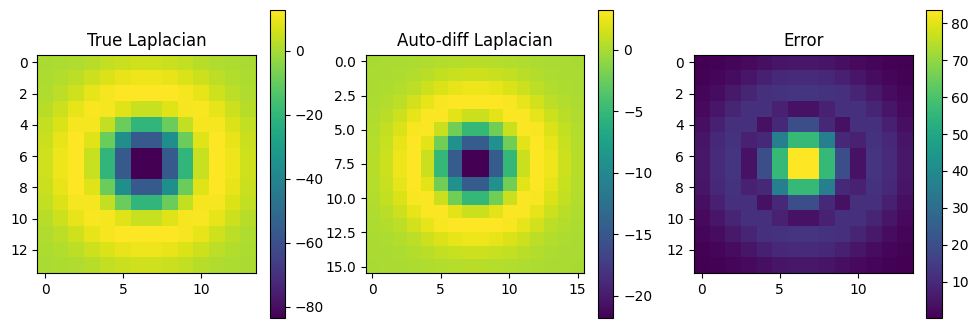

In [184]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class FVMDerivatives:
    def __init__(self, nx, ny, domain=None):
        # Default domain if none specified
        self.domain = domain or {
            'x': [-1, 1],  # [x_min, x_max]
            'y': [-1, 1],  # [y_min, y_max]
            'boundary_conditions': {
                'left': 0,
                'right': 0,
                'top': 0,
                'bottom': 0
            }
        }
        
        self.nx, self.ny = nx, ny
        self.dx = (self.domain['x'][1] - self.domain['x'][0])/nx
        self.dy = (self.domain['y'][1] - self.domain['y'][0])/ny
        
        # Generate grid
        self.x = torch.linspace(
            self.domain['x'][0] + self.dx/2, 
            self.domain['x'][1] - self.dx/2, 
            nx
        )
        self.y = torch.linspace(
            self.domain['y'][0] + self.dy/2,
            self.domain['y'][1] - self.dy/2,
            ny
        )
        
        # Create mesh
        self.X, self.Y = torch.meshgrid(self.x, self.y, indexing='ij')
        
    
    def laplacian(self, y_pred):
        """Calculate Laplacian using FVM"""
        y_pred = y_pred.squeeze()
        batch_size, nx , ny = y_pred.shape
        dx = 1 / nx
        dy = 1 / ny
        du_dx = (y_pred[:, 2:, 1:-1] - y_pred[:, :-2, 1:-1]) / (2 * dx)
        du_dy = (y_pred[:, 1:-1, 2:] - y_pred[:, 1:-1, :-2]) / (2 * dy)
        #print(du_dx.shape)
        #import sys ; sys.exit()
        # Calculate second derivatives
        d2u_dx2 = (y_pred[:, 2:, 1:-1] - 2*y_pred[:, 1:-1, 1:-1] + y_pred[:, :-2, 1:-1]) / dx**2
        d2u_dy2 = (y_pred[:, 1:-1, 2:] - 2*y_pred[:, 1:-1, 1:-1] + y_pred[:, 1:-1, :-2]) / dy**2

        laplacian = d2u_dx2 + d2u_dy2
        
        return laplacian

    def darcy_flow(self, u , k):
        """Calculate Darcy flow using FVM"""
        darcy_flow = torch.zeros_like(u)
        
        # Interior points
        darcy_flow[1:-1, 1:-1] = (
            (u[2:, 1:-1] - u[1:-1, 1:-1]) / self.dx +
            (u[1:-1, 2:] - u[1:-1, 1:-1]) / self.dy
        )
        
        darcy_flow = -k * darcy_flow #+ torch.ones_like(darcy_flow)
        

        return darcy_flow

    

# Example usage
x = torch.linspace(-1, 1, 16, requires_grad=True)
y = torch.linspace(-1, 1, 16, requires_grad=True)
X, Y = torch.meshgrid(x, y)
u = torch.exp(-1 * ((X)**2 + (Y)**2))

domain = {
    'x': [-1, 1],
    'y': [-1, 1],
    'boundary_conditions': {
        'left': u[:, 0],
        'right': u[:, -1],
        'top': u[-1, :],
        'bottom': u[0, :]
    }
}

fvm = FVMDerivatives(16, 16, domain=domain)

# Test function
X, Y = torch.meshgrid(fvm.x, fvm.y, indexing='ij')
X.requires_grad = True
Y.requires_grad = True
U =  []
for p in p_values[:3]:
    print(p)
    U.append(torch.exp(p * (-X**2 - Y**2)).unsqueeze(0))

U = torch.stack(U , dim = 0)
print(U.shape)
# Auto-diff Laplacian
i = 2
auto_lap = derivation(U[i] , X , order=2) + derivation(U[i] , Y , order=2)

# Calculate derivatives
#grad_x, grad_y = fvm.gradient(u)
Lap = fvm.laplacian(U)
#Lap = Lap.reshape(3, 16, 16)
lap = Lap[i]

error = torch.abs(lap - auto_lap[1 , -1]).max()

print(f'Gradient error: {error:.2e}')

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('True Laplacian') 
plt.imshow(lap.detach().numpy())
plt.colorbar()
plt.subplot(132)
plt.title('Auto-diff Laplacian')
plt.imshow(auto_lap.detach().numpy())
plt.colorbar()
plt.subplot(133)
plt.title('Error')
plt.imshow(torch.abs(lap - auto_lap[1 , -1]).detach().numpy())
plt.colorbar()
plt.show()


In [27]:
train_loader, test_loaders, _ = load_darcy_flow_small(
            n_train=500, batch_size=32,
            test_resolutions=[16, 32], n_tests=[100, 50],
            test_batch_sizes=[32, 32],
        )

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [107]:
k = train_loader.dataset[0]['x']
u = train_loader.dataset[0]['y']

f = fvm.darcy_flow(u, k)
print(f)
print(train_loader.dataset[1]['x'])


"""print(u_fdm[0])
#ploting the data
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Permeability')
plt.imshow(k.squeeze())
plt.colorbar()
plt.subplot(122)
plt.title('Pressure')
plt.imshow(u.squeeze())
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 4))

plt.title('FDM Darcy flow')
plt.imshow(u_fdm.squeeze())
plt.colorbar()"""


tensor(0.)
tensor([[[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,

"print(u_fdm[0])\n#ploting the data\nplt.figure(figsize=(12, 4))\nplt.subplot(121)\nplt.title('Permeability')\nplt.imshow(k.squeeze())\nplt.colorbar()\nplt.subplot(122)\nplt.title('Pressure')\nplt.imshow(u.squeeze())\nplt.colorbar()\nplt.show()\n\nplt.figure(figsize=(12, 4))\n\nplt.title('FDM Darcy flow')\nplt.imshow(u_fdm.squeeze())\nplt.colorbar()"

Gradient error: 3.18e+00


Text(0.5, 1.0, 'Error')

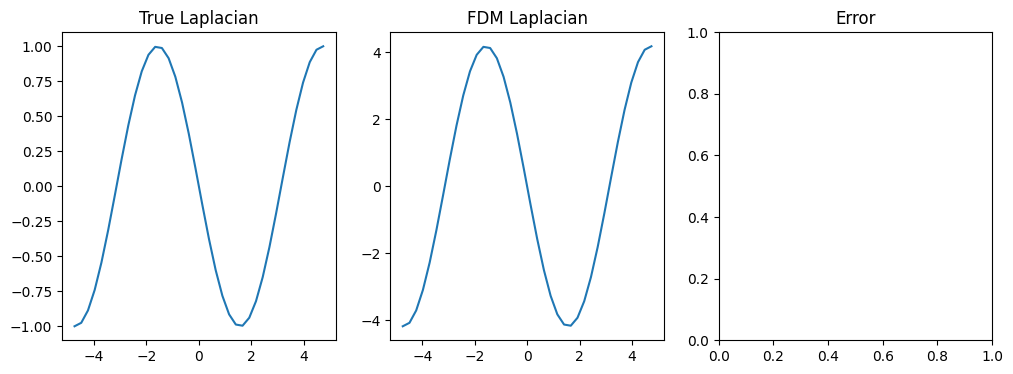

In [12]:
def laplacian2D(u , dx , dy) :

    laplacian = torch.zeros_like(u)
    
    # Interior points
    laplacian[1:-1, 1:-1] = (
        (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / (dx**2) +
        (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / (dy**2)
    )
    
    return laplacian

def laplacian1D(u , dx ) :

    laplacian = torch.zeros_like(u)
    
    # Interior points
    laplacian[1:-1] = (
        (u[2:] - 2 * u[1:-1] + u[:-2]) / (dx**2) 
    )
    
    return laplacian

x = torch.linspace(-5, 5, 40, requires_grad=True)
u = torch.sin(x)

d2u = laplacian1D(u , 1/8)
exact = -torch.sin(x)

error = torch.abs(d2u[1:-1] - exact[1:-1]).max()
print(f'Gradient error: {error:.2e}')


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('True Laplacian')
plt.plot(x[1:-1].detach().numpy(), exact.detach()[1:-1].numpy())
plt.subplot(132)
plt.title('FDM Laplacian')
plt.plot(x[1:-1].detach().numpy(), d2u.detach()[1:-1].numpy())
plt.subplot(133)
plt.title('Error')

    

In [360]:
class LossWrapper:
    def __init__(self, loss_fn):
        self.loss_fn = loss_fn
        self.fvm = FVMDerivatives(32, 32)

    def normalize_operator(self, operator):
        """Normalize PDE operator output"""
        return (operator - operator.mean()) / (operator.std() + 1e-8)
    
    def pde_loss(self, pred, **sample):
            
        batch_size = pred.shape[0] 
        #.reshape(batch_size* pred.shape[2]  , pred.shape[3]  )
        pred_f = self.fvm.laplacian(pred)

        u_exact = sample.get('y', sample.get('target'))
        f_exact = sample.get('x')
        fdm_f = self.fvm.laplacian(u_exact)
        
        # Compute loss and mask inf/nan values
        exact_f = sample['x']

        #loss = self.loss_fn(operator[: , : ,1 : -1,1 : -1], target[: , : ,1 : -1,1 : -1])
        #print(torch.mean(operator) , operator.shape)    
        #import sys ; sys.exit()
        loss = self.loss_fn(pred_f, fdm_f.squeeze()) 
        mask = torch.isfinite(loss)
        
        # Sum valid losses only
        total_loss = torch.where(mask, loss, torch.zeros_like(loss)).sum()
            
        return loss
    
    """def pde_loss(self, pred, **sample):
        batch_size = pred.shape[0]
        print(pred.shape , sample['x'].shape)
        import sys ; sys.exit()"""

        
    def calculate_buondary_conditions(self, u , **sample):
        u_exact = sample['y']
        u = u.squeeze()
        u_exact = u_exact.squeeze()
        
        
        if len(u.shape) == 2:
            u = u.unsqueeze(0)
            u_exact = u_exact.unsqueeze(0)
        
        boundary_conditions = {
            'left': u[:  , :, 0],
            'right': u[: , : , -1],
            'top': u[: , -1 , :],
            'bottom': u[ : , 0 , :]
        }

        exact_boundary_conditions = {
            'left': u_exact[: , :, 0],
            'right': u_exact[: , : , -1],
            'top': u_exact[: , -1 , :],
            'bottom': u_exact[ : , 0 , :]
        }


        loss = 0
        for key in boundary_conditions.keys():
            loss += self.loss_fn(boundary_conditions[key], exact_boundary_conditions[key])

        return loss
    
    def __call__(self, pred, **sample):
        target = sample.get('y', sample.get('target'))
        f_exact = sample.get('x')
        fdm_f = self.fvm.laplacian(target)
        fdm_error = F.mse_loss(fdm_f, f_exact[: , : ,1 : -1,1 : -1].squeeze())    
        pde_loss = self.pde_loss(pred, **sample)

        boundary_loss = self.calculate_buondary_conditions(pred, **sample)

        #print(f"pde_loss: {pde_loss} , boundary_loss: {boundary_loss} , error_mse: {error_mse}")
        #print(f"pde_loss: {pde_loss} , boundary_loss: {boundary_loss}")
        print(f"pde_loss: {pde_loss}, fdm exact {fdm_error} , data_loss: {boundary_loss}")
        return  self.loss_fn(pred, target) + pde_loss * 10**-5
    
    
class mse_loss:
    def __init__(self):
        self.loss_fn = F.mse_loss
    def __call__(self, pred, **sample):
        target = sample.get('y', sample.get('target'))
        return self.loss_fn(pred, target)


In [187]:
device = "cpu"
model = FNO(n_modes=(16, 16),
            in_channels=1,
            out_channels=1,
            hidden_channels=32,
            projection_channel_ratio=2)

model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [132]:
optimizer = AdamW(model.parameters(),
                                lr=0.01,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [361]:
import torch
import copy

def create_finetuning_model(original_model, learning_rate=1e-3):
    """Create copy of model for fine-tuning"""
    
    # Deep copy model and weights
    model_finetune = copy.deepcopy(original_model)
    
    # Create new optimizer
    optimizer = torch.optim.Adam(model_finetune.parameters(), lr=learning_rate)
    
    # Create scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                              step_size=100, 
                                              gamma=0.5)
    
    return model_finetune, optimizer, scheduler

# Usage

model_ft, optimizer_ft, scheduler_ft = create_finetuning_model(model , learning_rate=0.01)

# Verify weights are copied but separate
print("Original model first parameter:", 
      next(FNO_model.parameters())[0,0])
print("Fine-tune model first parameter:", 
      next(model_ft.parameters())[0,0])

Original model first parameter: tensor([-0.4473], grad_fn=<SelectBackward0>)
Fine-tune model first parameter: tensor([0.3813], grad_fn=<SelectBackward0>)


In [353]:
train_loaders , test_loaders = Train_Test_loaders(resolution=32, p_min=5, p_max=25 ,n_samples=50 ,u_exact = u_exact , operator = operator ,train_size = 0.8, batch_size = 32)

train_loader = train_loaders[32]
test_loader = test_loaders[32]

In [346]:
train_loader, test_loaders, _ = load_darcy_flow_small(
            n_train=500, batch_size=32,
            test_resolutions=[16, 32], n_tests=[100, 50],
            test_batch_sizes=[32, 32],
        )

c:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\src\neuraloperator\neuralop\data\datasets\pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


c:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\src\neuraloperator\neuralop\data\datasets\pt_dataset.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

In [362]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

pino_loss = LossWrapper(F.mse_loss)
train_loss =  pino_loss  #  , 'mse_loss' : LossWrapper(F.mse_loss) 
eval_losses={'h1': h1loss, 'l2': l2loss ,'mse_loss' : mse_loss() }

In [363]:
device = "cpu"
trainer = Trainer(model=model_ft, n_epochs= 100,
                  device=device,
                  wandb_log=True,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [364]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer_ft,
              scheduler= scheduler_ft,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 40 samples
Testing on [10] samples         on resolutions [32].
Raw outputs of shape torch.Size([32, 1, 32, 32])
pde_loss: 12971.7822265625, fdm exact 429.0685119628906 , data_loss: 0.021490968763828278
pde_loss: 207464.625, fdm exact 630.456298828125 , data_loss: 0.03676309436559677
[0] time=1.89, avg_loss=0.0612, train_err=1.2238
Eval: 32_h1=0.7412, 32_l2=0.7740, 32_mse_loss=0.0013
pde_loss: 1374.3275146484375, fdm exact 468.36370849609375 , data_loss: 0.030814096331596375
pde_loss: 8088.486328125, fdm exact 473.2754821777344 , data_loss: 0.025913843885064125
pde_loss: 3555.9013671875, fdm exact 463.9233703613281 , data_loss: 0.017811505123972893
pde_loss: 1734.2783203125, fdm exact 491.0367126464844 , data_loss: 0.009883634746074677
pde_loss: 1068.91455078125, fdm exact 490.56988525390625 , data_loss: 0.005406508222222328
pde_loss: 1650.4200439453125, fdm exact 384.45068359375 , data_loss: 0.003244011662900448
[3] time=0.43, avg_loss=0.0014, train_err=0.0287
Eval: 32_h1=

{'train_err': 5.63283683732152e-05,
 'avg_loss': 2.8164184186607598e-06,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.5400668999936897,
 '32_h1': tensor(0.0212),
 '32_l2': tensor(0.0188),
 '32_mse_loss': tensor(9.0385e-07)}

 '32_h1': tensor(0.0342),
 '32_l2': tensor(0.0144),
 '32_mse_loss': tensor(1.2699e-06)

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])


C:\Users\mohammed\AppData\Local\Temp\ipykernel_25284\3589208278.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


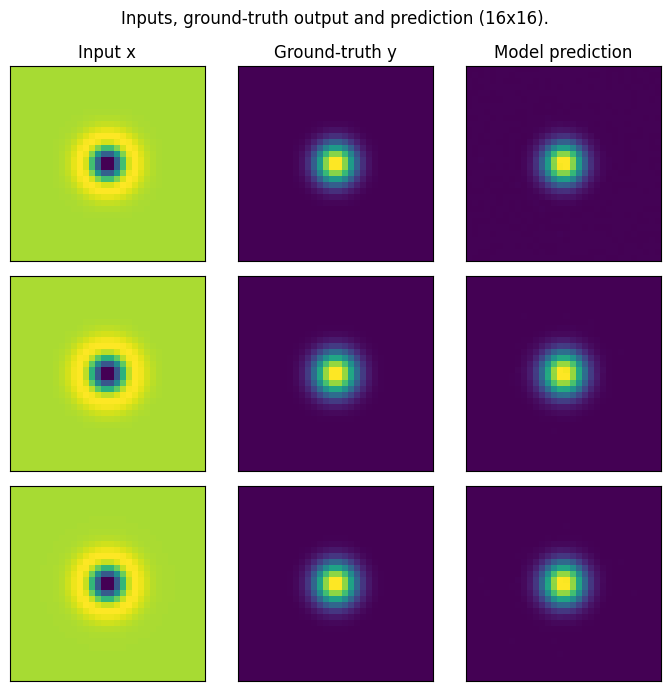

In [357]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    #data = data_processor.preprocess(data, bat
    # ched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    print(x.unsqueeze(0).shape)
    out = model_ft(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].detach().numpy())
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])


    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def test_model_parameters():
    # Test parameters
    resolutions = [16]
    p_values = [i for i in range(1, 20)]
    
    # Initialize error matrices
    mse_errors = np.zeros((len(resolutions), len(p_values)))
    h1_errors = np.zeros((len(resolutions), len(p_values)))
    l2_errors = np.zeros((len(resolutions), len(p_values)))
    
    # Run tests
    for i, res in enumerate(resolutions):
        for j, p in enumerate(p_values):
            # Generate grid
            x = torch.linspace(-1, 1, res, requires_grad=True)
            y = torch.linspace(-1, 1, res, requires_grad=True)
            x, y = torch.meshgrid(x, y)
            
            # Calculate solutions
            u_exact = torch.exp(p*(-x**2 - y**2))
            f = (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))
            u_pred = model(f.reshape(1, 1, res, res))
            
            # Calculate errors
            mse_errors[i,j] = F.mse_loss(u_pred.squeeze(), u_exact).item()
            h1_errors[i,j] = h1loss(u_pred.squeeze(), u_exact).item()
            l2_errors[i,j] = l2loss(u_pred.squeeze(), u_exact).item()
    
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # MSE errors
    sns.heatmap(mse_errors, ax=ax1, 
                xticklabels=p_values, 
                yticklabels=resolutions,
                cmap='viridis')
    ax1.set_title('MSE Error')
    ax1.set_xlabel('p value')
    ax1.set_ylabel('Resolution')
    
    # H1 errors
    sns.heatmap(h1_errors, ax=ax2,
                xticklabels=p_values,
                yticklabels=resolutions,
                cmap='viridis')
    ax2.set_title('H1 Error')
    ax2.set_xlabel('p value')
    
    # L2 errors
    sns.heatmap(l2_errors, ax=ax3,
                xticklabels=p_values,
                yticklabels=resolutions,
                cmap='viridis')
    ax3.set_title('L2 Error')
    ax3.set_xlabel('p value')
    
    plt.tight_layout()
    plt.show()
    
    return mse_errors, h1_errors, l2_errors

# Run tests
mse_errors, h1_errors, l2_errors = test_model_parameters()

# Print statistics
print(f"Mean MSE: {np.mean(mse_errors):.6f}")
print(f"Mean H1: {np.mean(h1_errors):.6f}")
print(f"Mean L2: {np.mean(l2_errors):.6f}")

NameError: name 'h1loss' is not defined

tensor(2.8760e-05, grad_fn=<MseLossBackward0>)
tensor(0.0736, grad_fn=<SqueezeBackward0>)
tensor(0.0389, grad_fn=<SqueezeBackward0>)


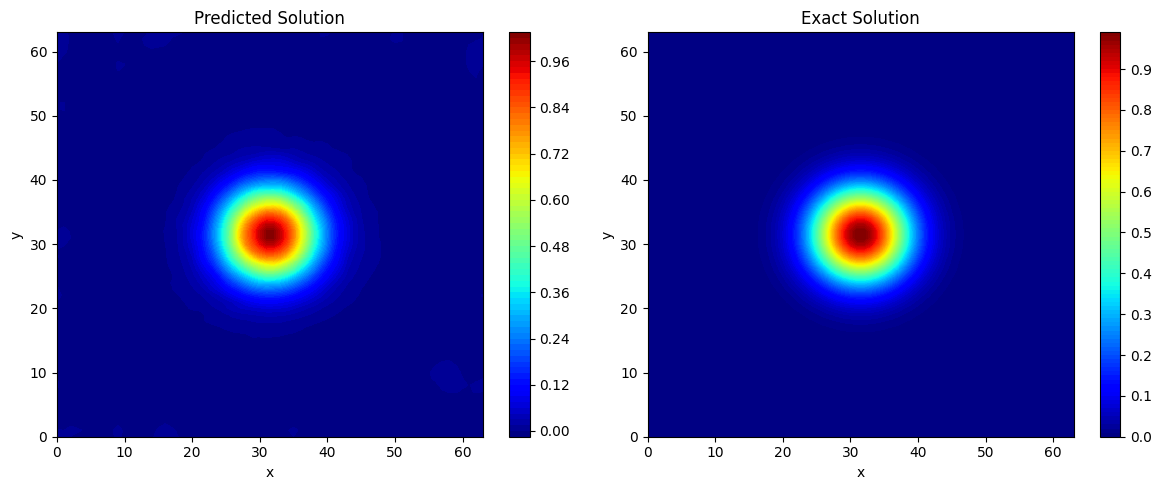

In [365]:
import torch.nn.functional as F


p = 20
resolution = 64

exact = lambda x, y, p: torch.exp(p*(-x**2 - y**2)) 
f_exact = lambda x, y, p: (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y)) 


x = torch.linspace(-1 , 1 , resolution , requires_grad = True)
y = torch.linspace(-1,1, resolution ,  requires_grad = True)

x,y = torch.meshgrid(x , y)

exact = u_exact((x), (y), p)
f = f_exact((x) , (y) , p)

u_pred = model_ft(f.reshape(1 ,1 ,resolution , resolution))


print(F.mse_loss(u_pred.squeeze() , exact))
print(h1loss(u_pred.squeeze() , exact))
print(l2loss(u_pred.squeeze() , exact))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Predicted solution
im1 = ax1.contourf(u_pred.squeeze().detach().numpy(), levels=100, cmap='jet')
plt.colorbar(im1, ax=ax1)
ax1.set_title('Predicted Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Exact solution
im2 = ax2.contourf(exact.squeeze().detach().numpy(), levels=100, cmap='jet')
plt.colorbar(im2, ax=ax2)
ax2.set_title('Exact Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()
plt.show()


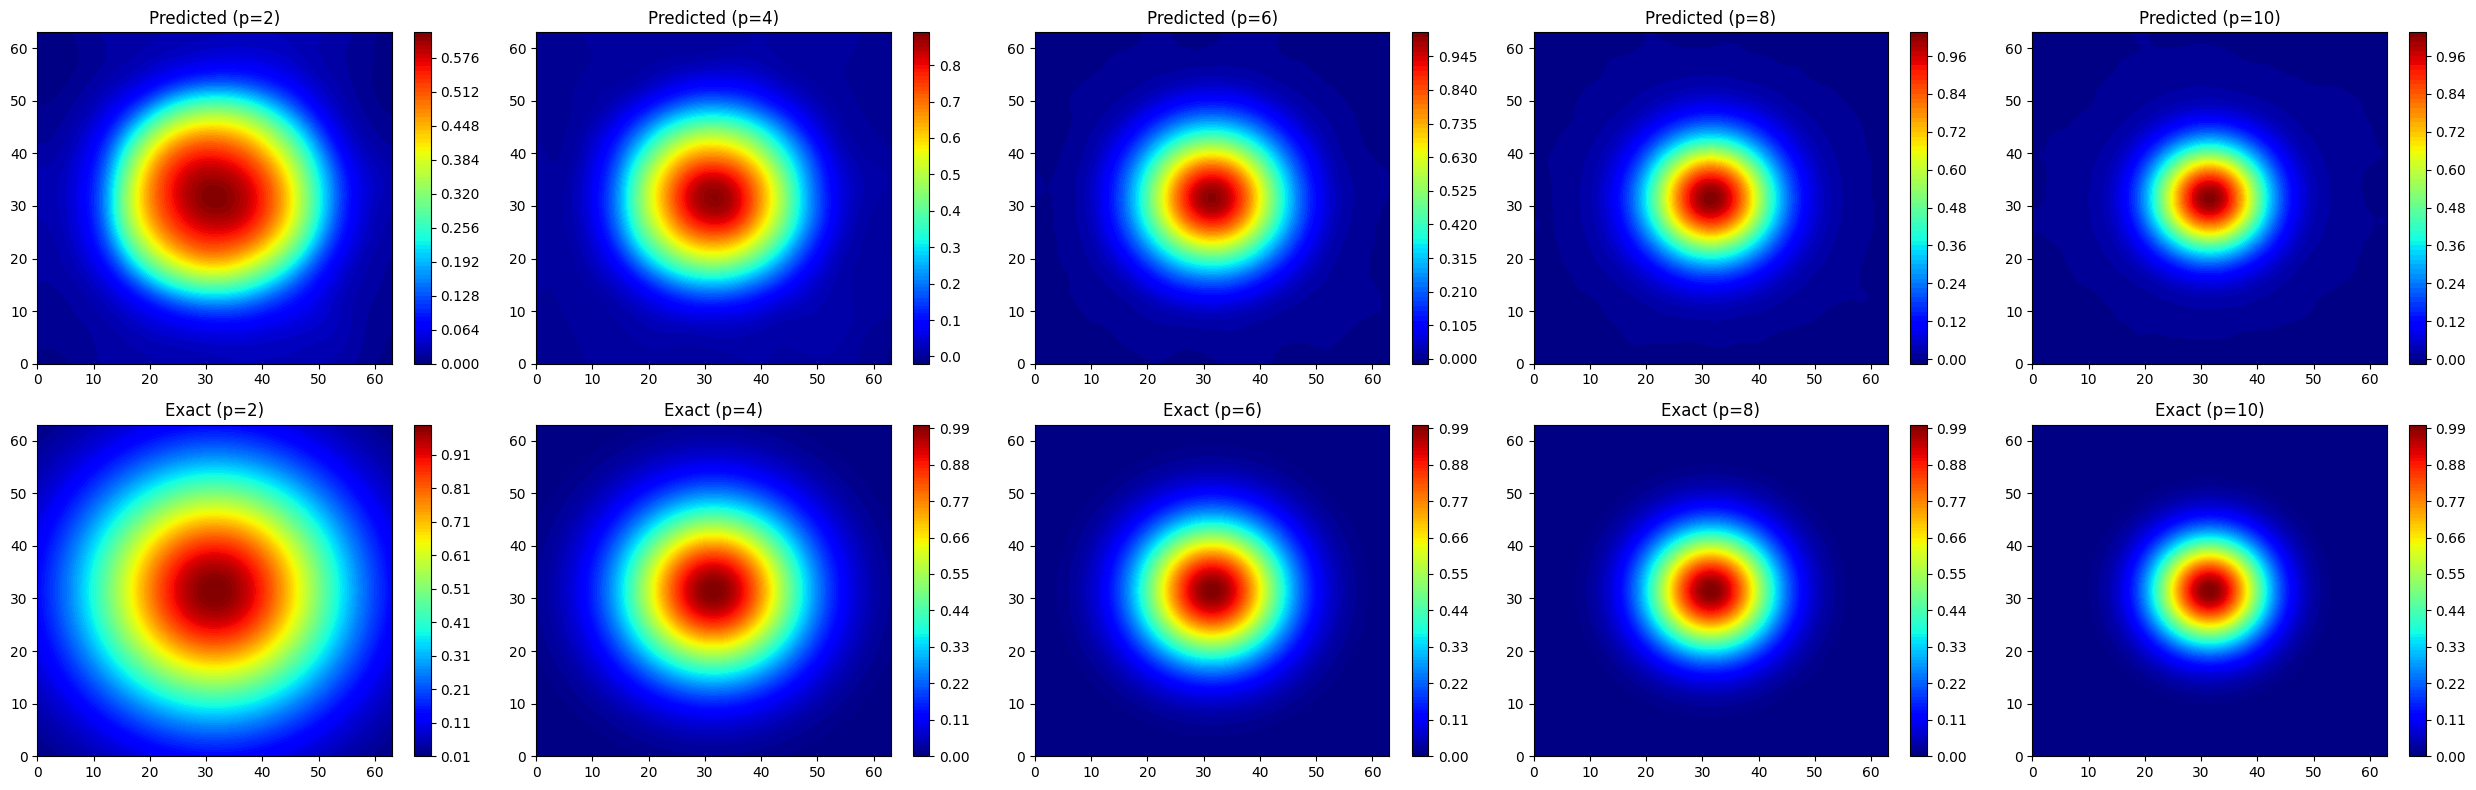

In [366]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Setup
p_values = [i*2 for i in range(1, 6)]
resolution = 64
x = torch.linspace(-1, 1, resolution, requires_grad=True)
y = torch.linspace(-1, 1, resolution, requires_grad=True)
x, y = torch.meshgrid(x, y)

# Create figure
fig, axes = plt.subplots(2, 5, figsize=(25, 8))

# Generate and plot solutions for each p
for idx, p in enumerate(p_values):
    # Calculate solutions
    u_exact_p = torch.exp(p*(-x**2 - y**2))
    f_p = (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))
    u_pred_p = model_ft(f_p.reshape(1, 1, resolution, resolution))
    
    # Plot predicted solution
    im1 = axes[0, idx].contourf(u_pred_p.squeeze().detach().numpy(), 
                               levels=100, cmap='jet')
    plt.colorbar(im1, ax=axes[0, idx])
    axes[0, idx].set_title(f'Predicted (p={p})')
    
    # Plot exact solution
    im2 = axes[1, idx].contourf(u_exact_p.squeeze().detach().numpy(), 
                               levels=100, cmap='jet')
    plt.colorbar(im2, ax=axes[1, idx])
    axes[1, idx].set_title(f'Exact (p={p})')

plt.tight_layout()
plt.show()

In [172]:
import pandas as pd
import torch
import torch.nn.functional as F
from typing import Dict, List

class TestPipeline:
    def __init__(self, models: Dict[str, torch.nn.Module], test_loaders: Dict[int, DataLoader]):
        self.models = models
        self.test_loaders = test_loaders
        
    def evaluate_model(self, model: torch.nn.Module, loader: DataLoader) -> Dict:
        """Evaluate single model on single test loader"""
        model.eval()
        metrics = {
            'MSE': 0.0,
            'L2': 0.0,
            'H1' : 0.0,
            'MAE' : 0.0,
            'Interior_MSE': 0.0,
            'Boundary_MSE': 0.0
        }
        
        with torch.no_grad():
            for batch in loader:
                x, y_true = batch['x'], batch['y']
                y_pred = model(x)
                
                # Calculate metrics
                metrics['MSE'] += F.mse_loss(y_pred, y_true).item()
                metrics['L2'] += self.l2_error(y_pred, y_true).item()
                metrics['H1'] += h1loss(y_pred, y_true).item()
                metrics['MAE'] += F.l1_loss(y_pred, y_true).item()
                
                # Interior vs boundary errors
                interior_mask = self.get_interior_mask(x)
                metrics['Interior_MSE'] += F.mse_loss(
                    y_pred[interior_mask], 
                    y_true[interior_mask]
                ).item()
                metrics['Boundary_MSE'] += F.mse_loss(
                    y_pred[~interior_mask],
                    y_true[~interior_mask]
                ).item()
        
        # Average metrics
        for key in metrics:
            metrics[key] /= len(loader)
            
        return metrics
    
    def run_tests(self) -> pd.DataFrame:
        """Run all models on all test loaders"""
        results = []
        
        for model_name, model in self.models.items():
            for res, loader in self.test_loaders.items():
                metrics = self.evaluate_model(model, loader)
                results.append({
                    'Model': model_name,
                    'Resolution': res,
                    **metrics
                })
        
        # Create DataFrame
        df = pd.DataFrame(results)
        df = df.set_index(['Model', 'Resolution'])
        
        # Format with scientific notation
        styled_df = df.style.format('{:.2e}')
        
        return styled_df
    
    @staticmethod
    def l2_error(pred, true):
        return torch.sqrt(torch.sum((pred - true) ** 2))
    

    
    @staticmethod
    def get_interior_mask(x):
        """Create mask for interior points"""
        return torch.prod(torch.abs(x) < 0.9, dim=-1)
    


# Usage
models = {
    'CNN' : CNN_model,
    'FNO': FNO_model,
    'TFNO': TFNO_model,
    'UNO': UNO_model,
    'PINO': model_ft
}   

test_pipeline = TestPipeline(models, test_loaders)
results_df = test_pipeline.run_tests()
display(results_df)